In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3

In [3]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid, params1, params2, params3):
    
    return np.exp(lnf_w(x_twid, params1, params2, params3)) / (np.exp(lnf_w(1., params1, params2, params3)))

In [4]:
print(np.exp(lnf_w((5.8e-4*0.68/(omega_0*f_btwid)),params1,params2,params3)))

16906.138095864884


In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(T_twid, x_twid, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600. #[K]
    
    f_w = np.exp(lnf_w(x_twid,params1,params2,params3)) #lnf_w needs non-dimensionalized x
    
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    if f_w > f_w_min:
        return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))
    else:
        return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid * omega_0 * f_btwid / f_M # mantle water mass fraction
    T = T_twid * T_ref #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T_twid,x_twid,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def tau_decay_twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return 2.0e9*year/(rho_m*c_p*T_ref/F_0(M,params1,params2,params3))
    # return 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay

def F_0twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return F_0(M,params1,params2,params3)/Q_0

def Ra(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (alpha*rho_m*g(M)*(T_twid*1600. - T_s)*(h(M)**3))/(eta(T_twid, x_twid, params1, params2, params3)*kappa)

In [7]:
# Things that need to be calculated with constants and above functions:
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
eta_0 = 1.e21/eta_scale
f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = f_w_min/np.exp(lnf_w(1.,params1,params2,params3)) #CONSERVATIVELY CHOSEN AS 1e-5 FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

In [8]:
print(f_w_min)
#print(f_w)
#print(f_wtwid_min)
#print(1*omega_0*f_btwid/f_M)
#print(0.0004*f_M/(omega_0*f_btwid))
print(f_btwid)

0.09
1.3


In [9]:
print(1*omega_0*f_btwid/f_M)

0.0004397058823529411


# Steady-state Parameter Space

In [10]:
# First thing we want to do: find the steady state for a variety of initial total water.
# To do this, a) NO loss, and b) DON'T include thermal evolution.
# But can change the initial mantle temp & find different steady states.

# Initial total water -- 1 ocean = 1.4e21 kg
# This wil be divided up before the simulations are run.
initial_total_water_array = np.array([0.1*1.4e21, 1*1.4e21, 5*1.4e21, 10*1.4e21, 25*1.4e21, 50*1.4e21, 100*1.4e21])/M_E/(omega_0*f_btwid)

# Loss rate -- doesn't matter here, NO loss
loss_factor_array = np.array([0.]) #NO LOSS

# Different temperatures to obtain a steady state.
#initial_temp_array = np.array([3200, 2500, 2000, 1500, 1200])
initial_temp_array = np.array([3200, 2500, 2000])

# Initialize Hybrid Model

In [11]:
# Define functions to be used in hybrid model, originally from SS model.

def D(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M, params1, params2, params3, params4):
    
    return D(M, params1, params2, params3, params4)/Sigma(M, params1, params2, params3, params4)

def Pitwid(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/D(M, params1, params2, params3, params4)

def D_2(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1., params1, params2, params3))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(1.+beta))
    else:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_min**beta)*((temp_twid-T_stwid)**(1.+beta))

def Pitwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

#tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [12]:
# Define variables specific to the hybrid model.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [13]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    #if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
    #    return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
    #        ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    ##elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    #else:
    #    return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
    #        ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    
    #NO thermal evolution
    return 0.

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
         #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif s_twid <= 0.:
                dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0. 
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        #Mantle water capacity check        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0:
             dx_twid = 0. - 0.
                
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though) + solidus temperature check
        
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #mantle temperature below solidus, degassing shuts off
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor # EXTREME loss
    
    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
        else: #mantle temperature below solidus, degassing shuts off
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [14]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid <= 0.:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Solidus temperature check
    if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling

        # Degassing check from CA2014
        if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        elif x_twid > 0. and s_twid <= 0.:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
            return 0.
        
    else: #mantle temperature below solidus, degassing shuts off
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor #EXTREME loss

    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    #if s_twid > 0.: #normal loss
    return (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    #elif s_twid <= 0.: #no loss
    #    return 0.

In [15]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

# Run parameter space for hybrid model

In [21]:
for kdx in range(0, len(initial_temp_array)):

    for jdx in range(0, len(initial_total_water_array)):
            
        #No loss!
        t_loss = 1.0e8
        loss_factor = 0.
    
        T_initial = initial_temp_array[kdx]
        
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4

        # Set initial conditions.
        t0 = 0.
        M = M_E
    
        # Divide water evenly between the two reservoirs. If mantle is saturated, put the rest of the water on surface.
        if (initial_total_water_array[jdx]/2.) <= 12.*1.4e21/M_E/(omega_0*f_btwid):
            initial_x = initial_total_water_array[jdx]/2.
            initial_s = initial_total_water_array[jdx]/2.
        else:
            initial_x = 12*1.4e21/M_E/(omega_0*f_btwid)
            initial_s = initial_total_water_array[jdx] - 12*1.4e21/M_E/(omega_0*f_btwid)
        
        z0 = [T_initial/T_ref, initial_x, initial_s]

        # Set up function to be integrated.
        r = ode(f_cycling_hyb).set_integrator('vode')
        r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

        # Define max time, timestep, arrays to be filled within the integration loop.
        t1 = 5.22 #~15 Gyr #100.
        dt = 1.e-5
        t_array_hyb = np.zeros(int(t1/dt)+1)
        T_array_hyb = np.zeros(int(t1/dt)+1)
        x_array_hyb = np.zeros(int(t1/dt)+1)
        s_array_hyb = np.zeros(int(t1/dt)+1)
        regas_array_hyb = np.zeros(int(t1/dt)+1)
        degas_array_hyb = np.zeros(int(t1/dt)+1)
        loss_array_hyb = np.zeros(int(t1/dt)+1)
        omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
        eta_array_hyb = np.zeros(int(t1/dt)+1)
                
        # Write results to file, for plotting later.
        save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_steadystate_alltemps/'
        save_file = 'steadystate_hyb_grid_T' + str(T_initial) + '_' + str(jdx) + '.txt'
        filename = os.path.join(save_path, save_file)
        f = open(filename, 'w')

        # Initial values in the arrays.
        t_array_hyb[0] = t0
        T_array_hyb[0] = z0[0]
        x_array_hyb[0] = z0[1]
        s_array_hyb[0] = z0[2]
        regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
        degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
        loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
        omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
        #eta_array_hyb[0] = eta(z0[0], z0[1], params1, params2, params3)
                
        f.write(str(t_array_hyb[0]) + '\t' + str(T_array_hyb[0]) + '\t' + str(x_array_hyb[0]) +\
                    '\t' + str(s_array_hyb[0]) + '\t' + str(degas_array_hyb[0]) + '\t' + str(regas_array_hyb[0]) + '\n')

        # Integrate the above function.
        #idx = 1
        #while r.successful() and r.t < t1:
        #start_time = time.time()
                                
        for idx in range(1,len(t_array_hyb)):
    
            if r.successful() == True:
                r.integrate(r.t+dt)
                t_array_hyb[idx] = r.t
                T_array_hyb[idx] = r.y[0]
                x_array_hyb[idx] = r.y[1]
                s_array_hyb[idx] = r.y[2]
                regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                #eta_array_hyb[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                # FULL RUNS. 
                f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                    '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\n')
        
            elif r.successful() == False:
        
                t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
                T_array_hyb[idx] = T_array_hyb[idx-1] + \
                    f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                x_array_hyb[idx] = x_array_hyb[idx-1] + \
                    f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                s_array_hyb[idx] = s_array_hyb[idx-1] + \
                    f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
                regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                #eta_array_hyb[idx] = eta(T_array_hyb[idx], x_array_hyb[idx], params1, params2, params3)
                        
                # FULL RUNS.
                f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                    '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\n')
        
                # Leave the loop if both reservoirs have zero water.
                if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
                    break
        
                #idx = idx + 1
    
        # THIS IS FOR (FIRST) SENSITIVITY CHECK
        #f.write(str(t_array_hyb[-1]) + '\t' + str(T_array_hyb[-1]) + '\t' + str(x_array_hyb[-1]) +\
        #    '\t' + str(s_array_hyb[-1]) + '\t' + str(regas_array_hyb[-1]) + '\t' + str(degas_array_hyb[-1]) + \
        #    '\t' + str(loss_array_hyb[idx]) + '\n') 
    
        f.close()
                
        #end_time = time.time()
        #print(end_time-start_time, ' s')
    
        # Mass of water in hydrated layer
        M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]          

# Plots of steady-state results.

In [23]:
filenums_ss_temp = []

for jdx in range(0, len(initial_total_water_array)):
                
    filenums_ss_temp = np.append(filenums_ss_temp, str(jdx))

In [24]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_steadystate_alltemps/'
kg_conv = 2.3e-4*1.3*M_E
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(initial_temp_array)))
s_initial_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(initial_temp_array)))

# Final water content in each reservoir
x_final_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(initial_temp_array)))
s_final_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(initial_temp_array)))

# Need length of data for the following arrays.
save_file = 'steadystate_hyb_grid_T3200_0.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array.
t_array_hyb = np.zeros(len(filenums_ss_temp))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(tmp_data),len(initial_temp_array)))
s_path_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(tmp_data),len(initial_temp_array)))

# Temperature doesn't evolve with these runs.
#T_path_hyb = np.zeros((len(filenums),len(tmp_data)))

# Overall evolution path for degassing and regassing rates.
degas_path_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(tmp_data),len(initial_temp_array)))
regas_path_hyb_ss_temp = np.zeros((len(filenums_ss_temp),len(tmp_data),len(initial_temp_array)))

# Temperature doesn't evolve with these runs.
#T_initial_hyb = np.zeros(len(filenums))
#T_final_hyb = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_ss_temp = 0.
s_zero_count_hyb_ss_temp = 0.
both_zero_count_hyb_ss_temp = 0.

for jdx in range(0,len(initial_temp_array)):

    for idx in range(0,len(filenums_ss_temp)):
        # Read in data files for each model, and save them as the evolutionary path.
        save_file = 'steadystate_hyb_grid_T' + str(initial_temp_array[jdx]) + '_' + filenums_ss_temp[idx] + '.txt'
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        #T_path_hyb[idx,:] = tmp_data[:,1]
        x_path_hyb_ss_temp[idx,:,jdx] = tmp_data[:,2]
        s_path_hyb_ss_temp[idx,:,jdx] = tmp_data[:,3]
        degas_path_hyb_ss_temp[idx,:,jdx] = tmp_data[:,4]
        regas_path_hyb_ss_temp[idx,:,jdx] = tmp_data[:,5]
    
        # Read in time array -- should be same for all, so only do once.
        if idx == 0 and jdx == 0:
            t_array_hyb = tmp_data[:,0]
    
        # Save initial and final values to corresponding arrays.
        x_initial_hyb_ss_temp[idx,jdx] = x_path_hyb_ss_temp[idx,0,jdx]
        s_initial_hyb_ss_temp[idx,jdx] = s_path_hyb_ss_temp[idx,0,jdx]
    
        #T_initial_hyb[idx] = T_path_hyb[idx,0]
    
        #T_final_hyb[idx] = T_path_hyb[idx,-1]
    
        # Check for zeros.     
        if x_path_hyb_ss_temp[idx,-1,jdx] <= tolerance and s_path_hyb_ss_temp[idx,-1,jdx] <= tolerance:
            both_zero_count_hyb_ss_temp = both_zero_count_hyb_ss_temp + 1.
            x_final_hyb_ss_temp[idx,jdx] = 0.
            s_final_hyb_ss_temp[idx,jdx] = 0.
        elif x_path_hyb_ss_temp[idx,-1,jdx] <= tolerance:
            x_zero_count_hyb_ss_temp = x_zero_count_hyb_ss_temp + 1.
            x_final_hyb_ss_temp[idx,jdx] = 0.
            s_final_hyb_ss_temp[idx,jdx] = s_path_hyb_ss_temp[idx,-1,jdx]
        elif s_path_hyb_ss_temp[idx,-1,jdx] <= tolerance:
            s_zero_count_hyb_ss_temp = s_zero_count_hyb_ss_temp + 1.
            s_final_hyb_ss_temp[idx,jdx] = 0.
            x_final_hyb_ss_temp[idx,jdx] = x_path_hyb_ss_temp[idx,-1,jdx]
        else: #neither is zero; save normally
            x_final_hyb_ss_temp[idx,jdx] = x_path_hyb_ss_temp[idx,-1,jdx]
            s_final_hyb_ss_temp[idx,jdx] = s_path_hyb_ss_temp[idx,-1,jdx]
        
#print('hyb zeros: ', 'x: ', x_zero_count_hyb, 's: ', s_zero_count_hyb, 'both: ', both_zero_count_hyb)

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(0.145, 0.155)

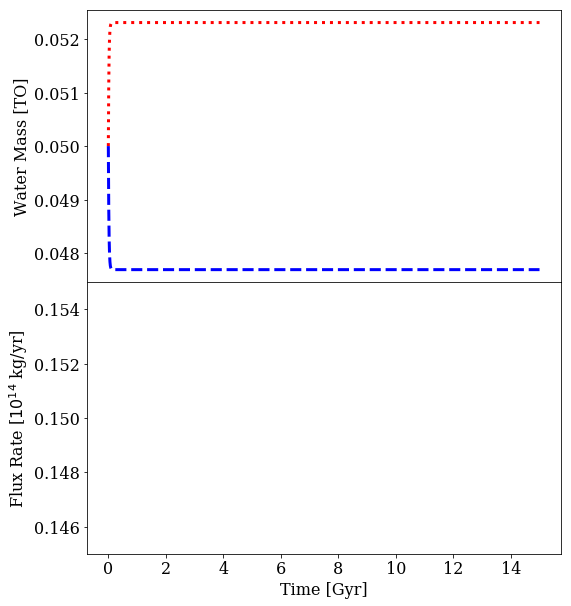

In [102]:
# Plot the cycling time evolution, to make sure they reach a steady-state.

# Change these to see different files.
idx = 0
jdx = 0

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1) #or semilogx
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_hyb_ss[idx,:,jdx]*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_path_hyb_ss[idx,:,jdx]*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
#plt.legend(loc='lower left', fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2) #or semilogx
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_path_hyb_ss[idx,:,jdx]*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_path_hyb_ss[idx,:,jdx]*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
#plt.legend(loc='upper right', fontsize=16)
plt.ylim([0.145,0.155])
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [25]:
# Just check for steady state in numbers.

kg_conv = 2.3e-4*1.3*M_E

for idx in range(0,len(filenums_ss_temp)):
    
    print(filenums_ss_temp[idx], ': initial water: ', initial_total_water_array[idx]*kg_conv/1.4e21, 'TO')
    
    for jdx in range(0,len(initial_temp_array)):
        
        print('Index: ', jdx, 'Temp: ', initial_temp_array[jdx], ': ', degas_path_hyb_ss_temp[idx,-1,jdx] - regas_path_hyb_ss_temp[idx,-1,jdx])

0 : initial water:  0.1 TO
Index:  0 Temp:  3200 :  2.712686910655293e-07
Index:  1 Temp:  2500 :  2.7804924140895082e-08
Index:  2 Temp:  2000 :  -1.6491545556537868e-05
1 : initial water:  1.0 TO
Index:  0 Temp:  3200 :  2.7494805010519485e-07
Index:  1 Temp:  2500 :  -4.433485727872721e-06
Index:  2 Temp:  2000 :  3.062726707803165e-07
2 : initial water:  5.000000000000001 TO
Index:  0 Temp:  3200 :  -4.732837055598793e-07
Index:  1 Temp:  2500 :  6.877141345285054e-08
Index:  2 Temp:  2000 :  3.7717518743818346e-06
3 : initial water:  10.000000000000002 TO
Index:  0 Temp:  3200 :  -2.6198591740467236e-07
Index:  1 Temp:  2500 :  2.3542403013721014e-06
Index:  2 Temp:  2000 :  -1.551817389255916e-05
4 : initial water:  25.000000000000004 TO
Index:  0 Temp:  3200 :  -5.153990510109452e-05
Index:  1 Temp:  2500 :  4.069122779526424e-05
Index:  2 Temp:  2000 :  2.8890546715842902e-05
5 : initial water:  50.00000000000001 TO
Index:  0 Temp:  3200 :  4.5756214603898115e-06
Index:  1 Temp

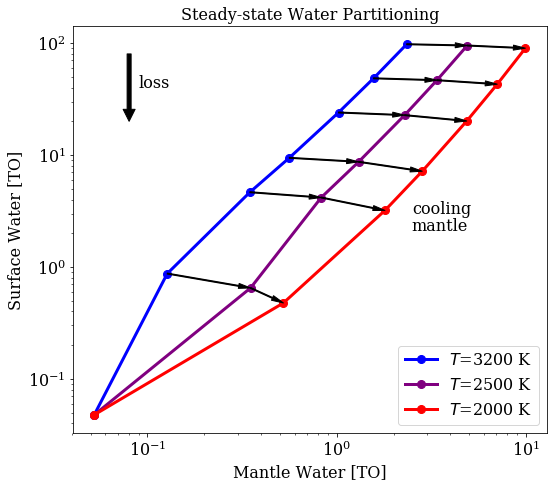

In [51]:
# Now let's try to plot these steady states on a plot of surface water vs. mantle water.

#color_array = ['blue', 'green', 'yellow', 'orange', 'red']
color_array = ['blue', 'purple', 'red']

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

# Plot temperature curves
for idx in range(0,3): #range(0,len(initial_temp_array)):
    
    #ss_label = 'T=' + str(initial_temp_array[idx]) + ' K' #IF THE BELOW DOESN'T WORK

    ax1.loglog(x_final_hyb_ss_temp[:,idx]*kg_conv/1.4e21, s_final_hyb_ss_temp[:,idx]*kg_conv/1.4e21, marker='o', markersize=8, color=color_array[idx], linestyle='-', linewidth=3, label=r'$T$=' + str(initial_temp_array[idx]) + ' K')

# Draw arrows connecting points to indicate cooling mantle.
for jdx in range(1,len(x_final_hyb_ss_temp[:,0])):
    
    ax1.annotate('',xy=(x_final_hyb_ss_temp[jdx,1]*kg_conv/1.4e21,s_final_hyb_ss_temp[jdx,1]*kg_conv/1.4e21), \
                xytext=(x_final_hyb_ss_temp[jdx,0]*kg_conv/1.4e21,s_final_hyb_ss_temp[jdx,0]*kg_conv/1.4e21), \
                arrowprops=dict(facecolor='k', shrink=0., width=1., headwidth=5.))
    
    ax1.annotate('',xy=(x_final_hyb_ss_temp[jdx,2]*kg_conv/1.4e21,s_final_hyb_ss_temp[jdx,2]*kg_conv/1.4e21), \
                xytext=(x_final_hyb_ss_temp[jdx,1]*kg_conv/1.4e21,s_final_hyb_ss_temp[jdx,1]*kg_conv/1.4e21), \
                arrowprops=dict(facecolor='k', shrink=0., width=1., headwidth=5.))
    
ax1.text(2.5, 3., 'cooling', fontsize=16)
ax1.text(2.5, 2.1, 'mantle', fontsize=16)

# Arrow indicating direction of loss
ax1.annotate("", xy=(0.08, 20.), xytext=(0.08, 80.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.09, 40, 'loss', fontsize=16)
    
ax1.set_xlabel('Mantle Water [TO]', fontsize=16)
ax1.set_ylabel('Surface Water [TO]', fontsize=16)
ax1.legend(loc='lower right', fontsize=16)
plt.title('Steady-state Water Partitioning', fontsize=16)
#plt.savefig('TotalWater_SteadyState_AllTemps_loglog.pdf', bbox_inches='tight')

In [24]:
# Check when the steady state is reached, for T=3200 K.

ss_tolerance = 1.0e-6 #can change this if we need a better defined steady-state, but this seems like a good value

for idx in range(0,len(filenums_ss_temp)):

    for jdx in range(0,len(t_array_hyb)):
        
        if np.abs(degas_path_hyb_ss_temp[idx, jdx, 0] - regas_path_hyb_ss_temp[idx, jdx, 0]) <= ss_tolerance:
            
            print(initial_total_water_array[idx]*kg_conv/1.4e21, 'TO :', t_array_hyb[jdx]/tau(M_E,params1,params2,params3)/year/1.0e9, 'Gyr')
            break    

0.1 TO : 0.22606652383820974 Gyr
1.0 TO : 0.23773187827113743 Gyr
5.000000000000001 TO : 0.4350372696281748 Gyr
10.000000000000002 TO : 0.551575884357289 Gyr
50.00000000000001 TO : 0.6346987177920342 Gyr
100.00000000000001 TO : 0.7683043781693472 Gyr


In [16]:
# Check for other two temperatures in final plot.

ss_tolerance = 1.0e-6 #can change this if we need a better defined steady-state, but this seems like a good value

for idx in range(0,len(filenums_ss_temp)):

    for jdx in range(0,len(t_array_hyb)):
        
        if np.abs(degas_path_hyb_ss_temp[idx, jdx, 2] - regas_path_hyb_ss_temp[idx, jdx, 2]) <= ss_tolerance:
            
            print(initial_total_water_array[idx]*kg_conv/1.4e21, 'TO :', t_array_hyb[jdx]/tau(M_E,params1,params2,params3)/year/1.0e9, 'Gyr')
            break  

1.0 TO : 4.726623475350262 Gyr
5.000000000000001 TO : 3.4124034956315072 Gyr
10.000000000000002 TO : 3.9691224796068156 Gyr
50.00000000000001 TO : 4.016329812940396 Gyr
100.00000000000001 TO : 3.3688164447081723 Gyr


In [25]:
# Calculate mantle overturn timescale by advection, given this temperature and steady-state water contents.

tau_over_adv_ss_temp = np.zeros(len(filenums_ss_temp))

for idx in range(0,len(filenums_ss_temp)):
    
    tau_over_adv_ss_temp[idx] = (eta(3200.0/1600., x_final_hyb_ss_temp[idx,0], params1, params2, params3) / (alpha*rho_m*(3200.-T_s)*\
                    g(M_E)*h(M_E))) * (Ra(3200.0/1600., x_final_hyb_ss_temp[idx,0], M_E, params1, params2, params3)/Ra_c)**(1./3.)

    print(initial_total_water_array[idx]*kg_conv/1.4e21, 'TO :', tau_over_adv_ss_temp[idx]/year/1.0e9, 'Gyr')

0.1 TO : 1.0090956825430555e-06 Gyr
1.0 TO : 5.175467030504679e-07 Gyr
5.000000000000001 TO : 2.1448436805259864e-07 Gyr
10.000000000000002 TO : 1.2935419087428688e-07 Gyr
50.00000000000001 TO : 3.336038919590461e-08 Gyr
100.00000000000001 TO : 1.721076410035871e-08 Gyr


In [26]:
# Calculate the overturn timescale for Earth today, to get an idea.
# Let's take Earth's mantle temp as 1600 K (since this is the pot'l temp at 200 km depth.)

tau_over_adv_E = (eta(1., 1.32, params1, params2, params3) / (alpha*rho_m*(1600.-T_s)*\
                    g(M_E)*h(M_E))) * (Ra(1., 1.32, M_E, params1, params2, params3)/Ra_c)**(1./3.)

print(tau_over_adv_E/year/1.0e9, 'Gyr')

0.00022428763447012668 Gyr


In [27]:
# Let's do the same as the above 2 cells, but now for the CONVECTIVE mantle overturn timescale.
nu = 2.5e17 #[m^2/s]
#tau_over_conv_ss = np.zeros(len(filenums))

#for idx in range(0,len(filenums)):
    
#    tau_over_conv_ss[idx] = (1./(5.38*kappa)) * (nu*kappa*Ra_c/(alpha*g(M_E)*(3200.-T_s)))**(2./3.)

tau_over_conv_ss_temp = (1./(5.38*kappa)) * (nu*kappa*Ra_c/(alpha*g(M_E)*(3200.-T_s)))**(2./3.)
    
print(tau_over_conv_ss_temp/year/1.0e9, 'Gyr')

0.036120103377533304 Gyr


In [28]:
# Convective overturn timescale for Earth today.

tau_over_conv_E = (1./(5.38*kappa)) * (nu*kappa*Ra_c/(alpha*g(M_E)*(1600.-T_s)))**(2./3.)

print(tau_over_conv_E/year/1.0e9, 'Gyr')

0.06132274656715753 Gyr


# Steady-state runs -- start from 4 initial total waters, and run to steady-state, same as above, with NO thermal evolution, using T_0 = 3200 K.

In [16]:
# Initial total water -- 1 ocean = 1.4e21 kg
# This wil be divided up before the simulations are run.
initial_total_water_array = np.array([0.1*1.4e21, 1*1.4e21, 10*1.4e21, 25*1.4e21])/M_E/(omega_0*f_btwid)

In [57]:
for jdx in range(0, len(initial_total_water_array)):
            
    #No loss!
    t_loss = 1.0e8
    loss_factor = 0.
    
    T_initial = 3200.
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
        eta_scale, eta_0, f_w, f_wtwid_min, E = params4

    # Set initial conditions.
    t0 = 0.
    M = M_E
    
    # Divide water evenly between the two reservoirs. If mantle is saturated, put the rest of the water on surface.
    if (initial_total_water_array[jdx]/2.) <= 12.*1.4e21/M_E/(omega_0*f_btwid):
        initial_x = initial_total_water_array[jdx]/2.
        initial_s = initial_total_water_array[jdx]/2.
    else:
        initial_x = 12*1.4e21/M_E/(omega_0*f_btwid)
        initial_s = initial_total_water_array[jdx] - 12*1.4e21/M_E/(omega_0*f_btwid)
        
    z0 = [T_initial/T_ref, initial_x, initial_s]

    # Set up function to be integrated.
    r = ode(f_cycling_hyb).set_integrator('vode')
    r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

    # Define max time, timestep, arrays to be filled within the integration loop.
    t1 = 5.22 #~15 Gyr #100.
    dt = 1.e-5
    t_array_hyb = np.zeros(int(t1/dt)+1)
    T_array_hyb = np.zeros(int(t1/dt)+1)
    x_array_hyb = np.zeros(int(t1/dt)+1)
    s_array_hyb = np.zeros(int(t1/dt)+1)
    regas_array_hyb = np.zeros(int(t1/dt)+1)
    degas_array_hyb = np.zeros(int(t1/dt)+1)
    loss_array_hyb = np.zeros(int(t1/dt)+1)
    omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
    eta_array_hyb = np.zeros(int(t1/dt)+1)
                
    # Write results to file, for plotting later.
    save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_steadystate/'
    save_file = 'steadystate_hyb_grid' + str(jdx) + '.txt'
    filename = os.path.join(save_path, save_file)
    f = open(filename, 'w')

    # Initial values in the arrays.
    t_array_hyb[0] = t0
    T_array_hyb[0] = z0[0]
    x_array_hyb[0] = z0[1]
    s_array_hyb[0] = z0[2]
    regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
    degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
    loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
    omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
    #eta_array_hyb[0] = eta(z0[0], z0[1], params1, params2, params3)
                
    f.write(str(t_array_hyb[0]) + '\t' + str(T_array_hyb[0]) + '\t' + str(x_array_hyb[0]) +\
                '\t' + str(s_array_hyb[0]) + '\t' + str(degas_array_hyb[0]) + '\t' + str(regas_array_hyb[0]) + '\n')

    # Integrate the above function.
    #idx = 1
    #while r.successful() and r.t < t1:
    #start_time = time.time()
                                
    for idx in range(1,len(t_array_hyb)):
    
        if r.successful() == True:
            r.integrate(r.t+dt)
            t_array_hyb[idx] = r.t
            T_array_hyb[idx] = r.y[0]
            x_array_hyb[idx] = r.y[1]
            s_array_hyb[idx] = r.y[2]
            regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
            degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
            loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
            omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
            #eta_array_hyb[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
            # FULL RUNS. 
            f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\n')
        
        elif r.successful() == False:
        
            t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
            T_array_hyb[idx] = T_array_hyb[idx-1] + \
                f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
            x_array_hyb[idx] = x_array_hyb[idx-1] + \
                f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
            s_array_hyb[idx] = s_array_hyb[idx-1] + \
                f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
            regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
            degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
            loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
            omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
            #eta_array_hyb[idx] = eta(T_array_hyb[idx], x_array_hyb[idx], params1, params2, params3)
                        
            # FULL RUNS.
            f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\n')
        
            # Leave the loop if both reservoirs have zero water.
            if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
                break
        
            #idx = idx + 1
    
    # THIS IS FOR (FIRST) SENSITIVITY CHECK
    #f.write(str(t_array_hyb[-1]) + '\t' + str(T_array_hyb[-1]) + '\t' + str(x_array_hyb[-1]) +\
    #    '\t' + str(s_array_hyb[-1]) + '\t' + str(regas_array_hyb[-1]) + '\t' + str(degas_array_hyb[-1]) + \
    #    '\t' + str(loss_array_hyb[idx]) + '\n') 
    
    f.close()
                
    #end_time = time.time()
    #print(end_time-start_time, ' s')
    
    # Mass of water in hydrated layer
    M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]          

## Read in data, and check to make sure it reached steady-state.

In [17]:
filenums_ss = []

for jdx in range(0, len(initial_total_water_array)):
                
    filenums_ss = np.append(filenums_ss, str(jdx))

In [18]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_steadystate/'
kg_conv = 2.3e-4*1.3*M_E
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_ss = np.zeros(len(filenums_ss))
s_initial_hyb_ss = np.zeros(len(filenums_ss))

# Final water content in each reservoir
x_final_hyb_ss = np.zeros(len(filenums_ss))
s_final_hyb_ss = np.zeros(len(filenums_ss))
                          
# Need length of data for the following arrays.
save_file = 'steadystate_hyb_grid0.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array.
t_array_hyb = np.zeros(len(filenums_ss))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_ss = np.zeros((len(filenums_ss),len(tmp_data)))
s_path_hyb_ss = np.zeros((len(filenums_ss),len(tmp_data)))

# Temperature doesn't evolve with these runs.
#T_path_hyb = np.zeros((len(filenums),len(tmp_data)))

# Overall evolution path for degassing and regassing rates.
degas_path_hyb_ss = np.zeros((len(filenums_ss),len(tmp_data)))
regas_path_hyb_ss = np.zeros((len(filenums_ss),len(tmp_data)))

# Temperature doesn't evolve with these runs.
#T_initial_hyb = np.zeros(len(filenums))
#T_final_hyb = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_ss = 0.
s_zero_count_hyb_ss = 0.
both_zero_count_hyb_ss = 0.

for idx in range(0,len(filenums_ss)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'steadystate_hyb_grid' + filenums_ss[idx] + '.txt'
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    #T_path_hyb[idx,:] = tmp_data[:,1]
    x_path_hyb_ss[idx,:] = tmp_data[:,2]
    s_path_hyb_ss[idx,:] = tmp_data[:,3]
    degas_path_hyb_ss[idx,:] = tmp_data[:,4]
    regas_path_hyb_ss[idx,:] = tmp_data[:,5]
    
    # Read in time array -- should be same for all, so only do once.
    if idx == 0:
        t_array_hyb = tmp_data[:,0]
    
    # Save initial and final values to corresponding arrays.
    x_initial_hyb_ss[idx] = x_path_hyb_ss[idx,0]
    s_initial_hyb_ss[idx] = s_path_hyb_ss[idx,0]
    
    #T_initial_hyb[idx] = T_path_hyb[idx,0]
    
    #T_final_hyb[idx] = T_path_hyb[idx,-1]
    
    # Check for zeros.     
    if x_path_hyb_ss[idx,-1] <= tolerance and s_path_hyb_ss[idx,-1] <= tolerance:
        both_zero_count_hyb_ss = both_zero_count_hyb_ss + 1.
        x_final_hyb_ss[idx] = 0.
        s_final_hyb_ss[idx] = 0.
    elif x_path_hyb_ss[idx,-1] <= tolerance:
        x_zero_count_hyb_ss = x_zero_count_hyb_ss + 1.
        x_final_hyb_ss[idx] = 0.
        s_final_hyb_ss[idx] = s_path_hyb_ss[idx,-1]
    elif s_path_hyb_ss[idx,-1] <= tolerance:
        s_zero_count_hyb_ss = s_zero_count_hyb_ss + 1.
        s_final_hyb_ss[idx] = 0.
        x_final_hyb_ss[idx] = x_path_hyb_ss[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb_ss[idx] = x_path_hyb_ss[idx,-1]
        s_final_hyb_ss[idx] = s_path_hyb_ss[idx,-1]
        
#print('hyb zeros: ', 'x: ', x_zero_count_hyb, 's: ', s_zero_count_hyb, 'both: ', both_zero_count_hyb)

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(0.145, 0.155)

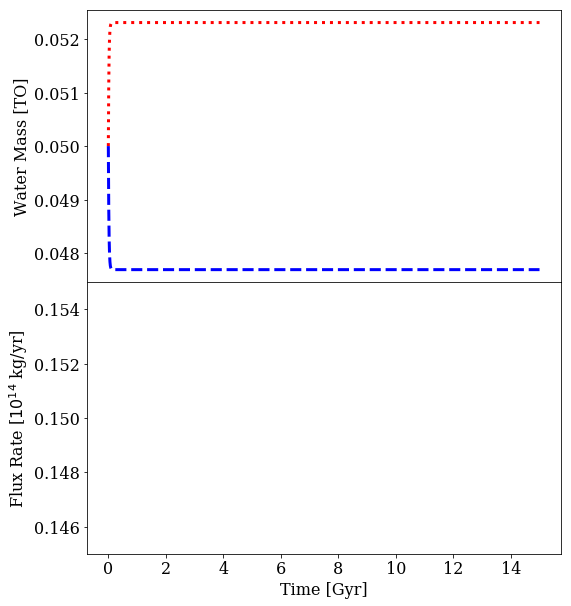

In [227]:
# Plot the cycling time evolution, to make sure they reach a steady-state.

# Change these to see different files.
idx = 0

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1) #or semilogx
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_hyb_ss[idx,:]*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_path_hyb_ss[idx,:]*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
#plt.legend(loc='lower left', fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2) #or semilogx
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_path_hyb_ss[idx,:]*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.plot(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_path_hyb_ss[idx,:]*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
#plt.legend(loc='upper right', fontsize=16)
plt.ylim([0.145,0.155])
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [34]:
# Just check for steady state in numbers.

kg_conv = 2.3e-4*1.3*M_E
rate_mult_hyb = (E/(Sigma(M_E,params1,params2,params3,params4)*tau(M_E,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]

for idx in range(0,len(filenums_ss)):
    
    print(filenums_ss[idx], ': initial water: ', initial_total_water_array[idx]*kg_conv/1.4e21, 'TO')
    print(rate_mult_hyb*(degas_path_hyb_ss[idx,-1] - regas_path_hyb_ss[idx,-1])*dr_conv/1.0e14, '10^14 kg/yr')

0 : initial water:  0.1 TO
6.156416296843554e-10 10^14 kg/yr
1 : initial water:  1.0 TO
6.239918988823086e-10 10^14 kg/yr
2 : initial water:  10.000000000000002 TO
-5.945744660462912e-10 10^14 kg/yr
3 : initial water:  25.000000000000004 TO
-1.1696930834730917e-07 10^14 kg/yr


In [35]:
# Check when the steady state is reached, for T=3200 K.

ss_tolerance = rate_mult_hyb*1.0e-5*dr_conv/1.0e14 #can change this if we need a better defined steady-state, but this seems like a good value

for idx in range(0,len(filenums_ss)):

    for jdx in range(0,len(t_array_hyb)):
        
        if np.abs(rate_mult_hyb*(degas_path_hyb_ss[idx, jdx] - regas_path_hyb_ss[idx, jdx])*dr_conv/1.0e14) <= ss_tolerance:
            
            print(initial_total_water_array[idx]*kg_conv/1.4e21, 'TO :', t_array_hyb[jdx]/tau(M_E,params1,params2,params3)/year/1.0e9, 'Gyr')
            break    

0.1 TO : 0.22322201623018056 Gyr
1.0 TO : 0.23701356826910988 Gyr
10.000000000000002 TO : 0.5485877147488502 Gyr
25.000000000000004 TO : 1.0032204812327685 Gyr


# Run an actual cycling parameter space.

## Use the steady-state values for T=3200 K as the initial values for surface water and mantle water.

In [19]:
# Parameter space

# Steady-state water partitioning from above -- Can narrow this down to 4 instead of 6
# 1) This first bit is for multiple temperatures.
#initial_x_array = x_final_hyb_ss[:,0]
#initial_s_array = s_final_hyb_ss[:,0]
# 2) This one is for using only a single temperature to find steady state.
initial_x_array = x_final_hyb_ss
initial_s_array = s_final_hyb_ss

# Try with 2 loss rates, 2 loss timescales for now.
#loss_rate_array = np.array([10, 100])*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))
#loss_time_array = np.array([1.0e7, 1.0e8])

# LATER --- 4 loss rates, 4 loss timescales.
loss_rate_array = np.array([0.1, 1, 10, 100])*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))
loss_time_array = np.array([1.0e6, 1.0e7, 1.0e8, 1.0e9])

In [20]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
         #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif s_twid <= 0.:
                dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0. 
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        #Mantle water capacity check        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0:
             dx_twid = 0. - 0.
                
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though) + solidus temperature check
        
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #mantle temperature below solidus, degassing shuts off
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor # EXTREME loss
    
    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
        else: #mantle temperature below solidus, degassing shuts off
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

## Run parameter search, with steady-state initial values.

In [315]:
for jdx in range(0, len(initial_x_array)):

    for kdx in range(0, len(loss_rate_array)):
        
        for ldx in range(0, len(loss_time_array)):
            
            t_loss = loss_time_array[ldx]
            loss_factor = loss_rate_array[kdx]
        
            M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
            x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
            params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
            omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
            omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                eta_scale, eta_0, f_w, f_wtwid_min, E = params4

            # Set initial conditions.
            t0 = 0.
            z0 = [2., initial_x_array[jdx], initial_s_array[jdx]]
            M = M_E
    
            # Set up function to be integrated.
            r = ode(f_cycling_hyb).set_integrator('vode')
            r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

            # Define max time, timestep, arrays to be filled within the integration loop.
            t1 = 5.22 #~15 Gyr #100.
            dt = 1.e-5
            t_array_hyb = np.zeros(int(t1/dt)+1)
            T_array_hyb = np.zeros(int(t1/dt)+1)
            x_array_hyb = np.zeros(int(t1/dt)+1)
            s_array_hyb = np.zeros(int(t1/dt)+1)
            regas_array_hyb = np.zeros(int(t1/dt)+1)
            degas_array_hyb = np.zeros(int(t1/dt)+1)
            loss_array_hyb = np.zeros(int(t1/dt)+1)
            omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
            eta_array_hyb = np.zeros(int(t1/dt)+1)
                
            # Write results to file, for plotting later.
            save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_init_steadystate/'
            save_file = 'cycling_hyb_steadystate' + str(jdx) + str(kdx) + str(ldx) + '.txt'
            filename = os.path.join(save_path, save_file)
            f = open(filename, 'w')

            # Initial values in the arrays.
            t_array_hyb[0] = t0
            T_array_hyb[0] = z0[0]
            x_array_hyb[0] = z0[1]
            s_array_hyb[0] = z0[2]
            regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
            degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
            loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
            omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
            #eta_array_hyb[0] = eta(z0[0], z0[1], params1, params2, params3)
                
            f.write(str(t_array_hyb[0]) + '\t' + str(T_array_hyb[0]) + '\t' + str(x_array_hyb[0]) +\
                        '\t' + str(s_array_hyb[0]) + '\t' + str(degas_array_hyb[0]) + '\t' + str(regas_array_hyb[0]) + \
                   '\t' + str(loss_array_hyb[0]) + '\n')

            # Integrate the above function.
            #idx = 1
            #while r.successful() and r.t < t1:
            #start_time = time.time()
                                
            for idx in range(1,len(t_array_hyb)):
    
                if r.successful() == True:
                    r.integrate(r.t+dt)
                    t_array_hyb[idx] = r.t
                    T_array_hyb[idx] = r.y[0]
                    x_array_hyb[idx] = r.y[1]
                    s_array_hyb[idx] = r.y[2]
                    regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                    degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                    loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                    omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                    #eta_array_hyb[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                    # FULL RUNS. 
                    f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                        '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + \
                        '\t' + str(loss_array_hyb[idx]) + '\n')
        
                elif r.successful() == False:
        
                    t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
                    T_array_hyb[idx] = T_array_hyb[idx-1] + \
                        f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                    x_array_hyb[idx] = x_array_hyb[idx-1] + \
                        f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                    s_array_hyb[idx] = s_array_hyb[idx-1] + \
                        f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
                    regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                    degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                    loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                    omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                    #eta_array_hyb[idx] = eta(T_array_hyb[idx], x_array_hyb[idx], params1, params2, params3)
                        
                    # FULL RUNS.
                    f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                        '\t' + str(s_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + \
                        '\t' + str(loss_array_hyb[idx]) + '\n')
        
                    # Leave the loop if both reservoirs have zero water.
                    if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
                        break
        
                    #idx = idx + 1
    
            # THIS IS FOR (FIRST) SENSITIVITY CHECK
            #f.write(str(t_array_hyb[-1]) + '\t' + str(T_array_hyb[-1]) + '\t' + str(x_array_hyb[-1]) +\
            #    '\t' + str(s_array_hyb[-1]) + '\t' + str(regas_array_hyb[-1]) + '\t' + str(degas_array_hyb[-1]) + \
            #    '\t' + str(loss_array_hyb[idx]) + '\n') 
    
            f.close()
                
            #end_time = time.time()
            #print(end_time-start_time, ' s')
    
            # Mass of water in hydrated layer
            M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]          

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


## Read in values from the above data files.

In [21]:
filenums = []
    
for jdx in range(0, len(initial_x_array)):
        
    for kdx in range(0, len(loss_rate_array)):
            
        for ldx in range(0, len(loss_time_array)):
                
            filenums = np.append(filenums, str(jdx)+str(kdx)+str(ldx))

In [22]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_init_steadystate/'
kg_conv = 2.3e-4*1.3*M_E
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array)))
s_initial_hyb = np.zeros((len(initial_s_array),len(loss_rate_array),len(loss_time_array)))

# Final water content in each reservoir
x_final_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array)))
s_final_hyb = np.zeros((len(initial_s_array),len(loss_rate_array),len(loss_time_array)))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_steadystate000.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array.
t_array_hyb = np.zeros(len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))
s_path_hyb = np.zeros((len(initial_s_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))

T_path_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))

# Overall evolution path for degassing and regassing rates.
degas_path_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))
regas_path_hyb = np.zeros((len(initial_s_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))
loss_path_hyb = np.zeros((len(initial_s_array),len(loss_rate_array),len(loss_time_array),len(tmp_data)))

T_initial_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array)))
T_final_hyb = np.zeros((len(initial_x_array),len(loss_rate_array),len(loss_time_array)))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb = 0.
s_zero_count_hyb = 0.
both_zero_count_hyb = 0.

for jdx in range(0,len(initial_x_array)):
    
    for kdx in range(0,len(loss_rate_array)):
        
        for ldx in range(0,len(loss_time_array)):

            # Read in data files for each model, and save them as the evolutionary path.
            save_file = 'cycling_hyb_steadystate' + str(jdx) + str(kdx) + str(ldx) + '.txt'
            filename = os.path.join(save_path, save_file)
            tmp_data = np.loadtxt(filename)
            T_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,1]
            x_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,2]
            s_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,3]
            degas_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,4]
            regas_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,5]
            loss_path_hyb[jdx,kdx,ldx,:] = tmp_data[:,6]
    
            # Read in time array -- should be same for all, so only do once.
            if jdx == 0 and kdx == 0 and ldx == 0:
                t_array_hyb = tmp_data[:,0]
    
            # Save initial and final values to corresponding arrays.
            x_initial_hyb[jdx,kdx,ldx] = x_path_hyb[jdx,kdx,ldx,0]
            s_initial_hyb[jdx,kdx,ldx] = s_path_hyb[jdx,kdx,ldx,0]
    
            T_initial_hyb[jdx,kdx,ldx] = T_path_hyb[jdx,kdx,ldx,0]
    
            T_final_hyb[jdx,kdx,ldx] = T_path_hyb[jdx,kdx,ldx,-1]
    
            # Check for zeros.     
            if x_path_hyb[jdx,kdx,ldx,-1] <= tolerance and s_path_hyb[jdx,kdx,ldx,-1] <= tolerance:
                both_zero_count_hyb = both_zero_count_hyb + 1.
                #x_final_hyb[jdx,kdx,ldx] = 0.
                #s_final_hyb[jdx,kdx,ldx] = 0.
            elif x_path_hyb[jdx,kdx,ldx,-1] <= tolerance:
                x_zero_count_hyb = x_zero_count_hyb + 1.
                #x_final_hyb[jdx,kdx,ldx] = 0.
                s_final_hyb[jdx,kdx,ldx] = s_path_hyb[jdx,kdx,ldx,-1]
            elif s_path_hyb[jdx,kdx,ldx,-1] <= tolerance:
                s_zero_count_hyb = s_zero_count_hyb + 1.
                #s_final_hyb[jdx,kdx,ldx] = 0.
                x_final_hyb[jdx,kdx,ldx] = x_path_hyb[jdx,kdx,ldx,-1]
            else: #neither is zero; save normally
                x_final_hyb[jdx,kdx,ldx] = x_path_hyb[jdx,kdx,ldx,-1]
                s_final_hyb[jdx,kdx,ldx] = s_path_hyb[jdx,kdx,ldx,-1]
        
print('hyb zeros: ', 'x: ', x_zero_count_hyb, 's: ', s_zero_count_hyb, 'both: ', both_zero_count_hyb)

hyb zeros:  x:  0.0 s:  10.0 both:  0.0


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


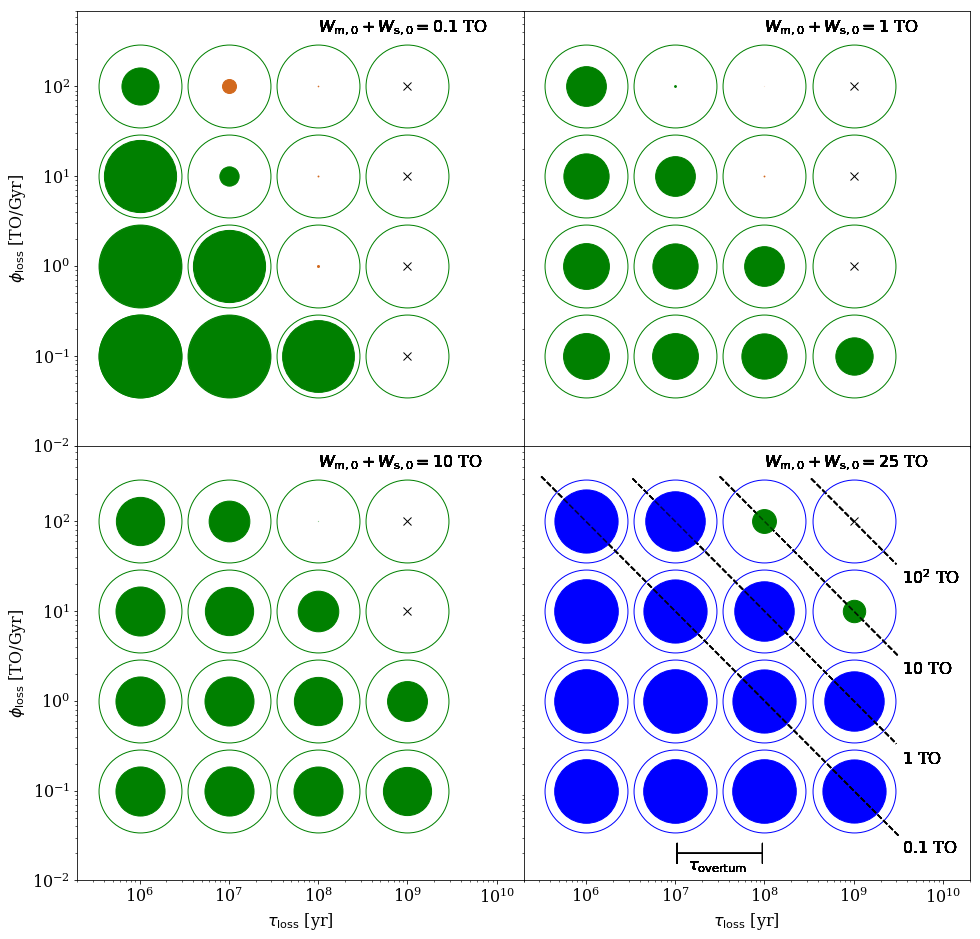

In [23]:
# Plot W_loss vs. t_loss, for a SINGLE initial total water (per panel). -- hopefully 4 panels later.
# Colour data points based on surface water regime.
# Have initial surface water be an empty circle, final water be a filled circle.
# XXXX If desiccated at end, either show nothing, or black X??? XXXX
# Size of circles indicate the amount of water. (bigger = more water)

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,16))
#ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)
rate_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))
#divide by this rate conversion
             
for idx in range(0,len(loss_rate_array)):
    
    for jdx in range(0,len(loss_time_array)):
        
        for kdx in range(0,len(initial_x_array)):
            
            ax1 = plt.subplot(2,2,kdx+1)
    
            # Choose corresponding colour for initial values.
            if s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
                init_color = 'chocolate' #Dune planet
            elif s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
                init_color = 'green' #habitable
            elif s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
                init_color = 'blue' #waterworld 
            
            # Choose marker size based on initial water. XXXX FIGURE OUT A GOOD WAY TO DO THIS XXXX
            init_size = s_initial_hyb[kdx,idx,jdx]*kg_conv/1.4e21*(65./s_initial_hyb[kdx,idx,jdx])

            # Choose corresponding colour for final values.
            if s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
                fin_color = 'black'
                fin_mark = 'x'
            elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
                fin_color = 'chocolate' #Dune planet
                fin_mark = 'o'
            elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
                fin_color = 'green' #habitable
                fin_mark = 'o'
            elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
                fin_color = 'blue' #waterworld
                fin_mark = 'o'
    
            # Choose marker size based on final water. XXXX FIGURE OUT A GOOD WAY TO DO THIS XXXX
            if fin_color == 'black':
                fin_size = 8
            else:
                fin_size = s_final_hyb[kdx,idx,jdx]*kg_conv/1.4e21*(65./s_initial_hyb[kdx,idx,jdx])
    
            # Plot initial and final water losses.
            plt.loglog(loss_time_array[jdx], loss_rate_array[idx]/rate_conv, fillstyle='none', color=init_color, marker='o', linestyle='', markersize=init_size)
            plt.loglog(loss_time_array[jdx], loss_rate_array[idx]/rate_conv, fillstyle='full', color=fin_color, marker=fin_mark, linestyle='', markersize=fin_size)
            #print(init_size, fin_size)
            
            # Axes labels, for each panel, and initial water amount
            if (kdx+1) == 1:
                plt.xticks([],[])
                plt.ylabel(r'$\phi_{\mathrm{loss}}$ [TO/Gyr]', fontsize=16)
                plt.text(1.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=0.1$ TO', fontsize=16)
                #plt.text(7.0e7, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=0.1$ TO', fontsize=16)
                
                plt.xlim(2.0e5, 4.0e9)
                plt.ylim(0.03, 700.0)
            elif (kdx+1) == 2:
                plt.xticks([],[])
                plt.yticks([],[])
                plt.text(1.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=1$ TO', fontsize=16)
                #plt.text(1.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=1$ TO', fontsize=16)
                
                plt.xlim(2.0e5, 4.0e9)
                plt.ylim(0.03, 700.0)
            elif (kdx+1) == 3:
                plt.xlabel(r'$\tau_{\mathrm{loss}}$ [yr]', fontsize=16)
                plt.ylabel(r'$\phi_{\mathrm{loss}}$ [TO/Gyr]', fontsize=16)
                plt.text(1.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=10$ TO', fontsize=16)
                #plt.text(7.0e7, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=10$ TO', fontsize=16)
                
                plt.xlim(2.0e5, 4.0e9)
                plt.ylim(0.03, 700.0)
            elif (kdx+1) == 4:
                # Also include lines for same phi_loss*tau_loss & indicate mantle overturn range in panel 4=.
                plt.xlabel(r'$\tau_{\mathrm{loss}}$ [yr]', fontsize=16)
                plt.text(1.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=25$ TO', fontsize=16)
                #plt.text(2.0e8, 4.0e2, r'$W_{\mathrm{m},0}+W_{\mathrm{s},0}=25$ TO', fontsize=16)
                
                # Diagonal lines indicating same phi_loss*tau_loss, and maximum water to be lost
                plt.loglog([(1.0e9)/3,(1.0e9)*3],[(1.0e2)*3,(1.0e2)/3], linestyle='--', color='k', alpha=0.3)
                plt.text(3.5e9, 2e1, r'$10^2$ TO', fontsize=16)
                plt.loglog([(np.sqrt(10.)*1e8)/10,(np.sqrt(10.)*1e8)*10],[(np.sqrt(10.)*1e1)*10,(np.sqrt(10.)*1e1)/10], linestyle='--', color='k', alpha=0.3)
                plt.text(3.5e9, 2, r'$10$ TO', fontsize=16)
                plt.loglog([(1.0e8)/30,(1.0e8)*30],[(1.0e1)*30,(1.0e1)/30], linestyle='--', color='k', alpha=0.3)
                plt.text(3.5e9, 0.2, r'$1$ TO', fontsize=16)
                plt.loglog([(np.sqrt(10.)*1e7)/100,(np.sqrt(10.)*1e7)*100],[(np.sqrt(10.)*1)*100,(np.sqrt(10.)*1)/100], linestyle='--', color='k', alpha=0.3)
                plt.text(3.5e9, 0.02, r'$0.1$ TO', fontsize=16)

                # Mantle overturn timescale range
                plt.annotate("", xy=(1.0e7, 2.0e-2), xytext=(1.0e8, 2.0e-2), arrowprops=dict(arrowstyle='|-|'))
                plt.text(1.4e7, 1.3e-2, r'$\tau_{\mathrm{overturn}}$', fontsize=16)
                
                #plt.xlim(2.0e5, 2.0e10)
                #plt.ylim(0.01, 700.0)
                plt.yticks([],[])
                
            plt.xlim(2.0e5, 2.0e10)
            plt.ylim(0.01, 700.0)
        
# Handles for legend only
#ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
#ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
#ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
#ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
#ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
#ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Grid_Parameter_Search_hyb_Wloss_tloss_surfacewater.pdf', bbox_inches='tight')

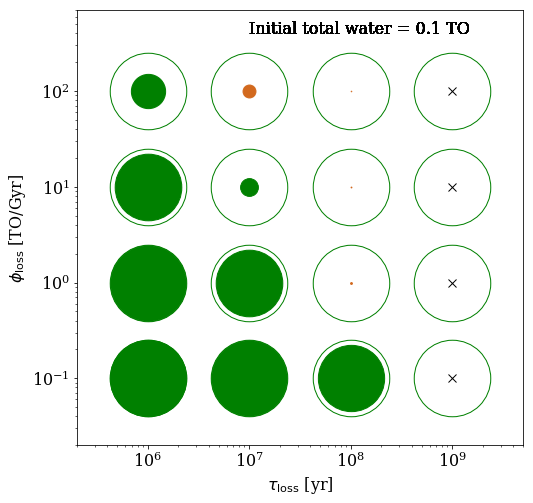

In [172]:
# One panel, so plots are more clear in presentation.
kdx = 0 #which panel of above figure to plot here

# Plot W_loss vs. t_loss, for a SINGLE initial total water (per panel). -- hopefully 4 panels later.
# Colour data points based on surface water regime.
# Have initial surface water be an empty circle, final water be a filled circle.
# XXXX If desiccated at end, either show nothing, or black X??? XXXX
# Size of circles indicate the amount of water. (bigger = more water)

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8,8))
#ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)
rate_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))
#divide by this rate conversion

ax1 = plt.subplot(1,1,1)
             
for idx in range(0,len(loss_rate_array)):
    
    for jdx in range(0,len(loss_time_array)):
        
        # Choose corresponding colour for initial values.
        if s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
            init_color = 'chocolate' #Dune planet
        elif s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
            init_color = 'green' #habitable
        elif s_initial_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
            init_color = 'blue' #waterworld 
            
        # Choose marker size based on initial water. XXXX FIGURE OUT A GOOD WAY TO DO THIS XXXX
        init_size = s_initial_hyb[kdx,idx,jdx]*kg_conv/1.4e21*(60./s_initial_hyb[kdx,idx,jdx])

        # Choose corresponding colour for final values.
        if s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
            fin_color = 'black'
            fin_mark = 'x'
        elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
            fin_color = 'chocolate' #Dune planet
            fin_mark = 'o'
        elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
            fin_color = 'green' #habitable
            fin_mark = 'o'
        elif s_final_hyb[kdx,idx,jdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
            fin_color = 'blue' #waterworld
            fin_mark = 'o'
    
        # Choose marker size based on final water. XXXX FIGURE OUT A GOOD WAY TO DO THIS XXXX
        if fin_color == 'black':
            fin_size = 8
        else:
            fin_size = s_final_hyb[kdx,idx,jdx]*kg_conv/1.4e21*(60./s_initial_hyb[kdx,idx,jdx])
    
        # Plot initial and final water losses.
        plt.loglog(loss_time_array[jdx], loss_rate_array[idx]/rate_conv, fillstyle='none', color=init_color, marker='o', linestyle='', markersize=init_size)
        plt.loglog(loss_time_array[jdx], loss_rate_array[idx]/rate_conv, fillstyle='full', color=fin_color, marker=fin_mark, linestyle='', markersize=fin_size)
        #print(init_size, fin_size)
            
        # initial water amount 
        if (kdx+1) == 1:
            plt.text(1.0e7, 4.0e2, 'Initial total water = 0.1 TO', fontsize=16, family='serif')
        elif (kdx+1) == 2:
            plt.text(1.0e7, 4.0e2, 'Initial total water = 1 TO', fontsize=16)
        elif (kdx+1) == 3:
            plt.text(1.0e7, 4.0e2, 'Initial total water = 10 TO', fontsize=16)
        elif (kdx+1) == 4:
            plt.text(1.0e7, 4.0e2, 'Initial total water = 25 TO', fontsize=16)

        plt.xlim(2.0e5, 5.0e9)
        plt.ylim(0.02, 700.0)
        plt.xlabel(r'$\tau_{\mathrm{loss}}$ [yr]', fontsize=16)
        plt.ylabel(r'$\phi_{\mathrm{loss}}$ [TO/Gyr]', fontsize=16)
        
# Handles for legend only
#ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
#ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
#ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
#ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
#ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
#ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
plt.savefig('Grid_Parameter_Search_hyb_Wloss_tloss_surfacewater_panel1.png', bbox_inches='tight')

In [305]:
#print(s_initial_hyb[4,0,0]*kg_conv/1.4e21)
#print(s_final_hyb[4,0,0]*kg_conv/1.4e21)
#print(s_initial_hyb[0,:,:]*kg_conv/1.4e21)
print(s_final_hyb[3,:,:]*kg_conv/1.4e21)

[[22.97301383 22.97193213 22.96089256 22.84914076]
 [22.97208725 22.96105435 22.85056645 21.73323401]
 [22.9614439  22.85188799 21.74980501 10.77738189]
 [22.85189465 21.76171449 11.04714603  0.        ]]


# Individual cycling plots, for paper

In [23]:
# Choose the indices for total water, loss factor, loss timescale from parameter space.
# For paper/Tomlinson I use 1,2,1 and 1,2,2
water_idx = 1 #total water; 0-3
factor_idx = 2 #loss factor; 0-3
time_idx = 2 #loss timescale; 0-3

In [24]:
rate_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))

print((x_initial_hyb[water_idx, factor_idx, time_idx]+s_initial_hyb[water_idx, factor_idx, time_idx])*kg_conv/1.4e21, 'TO')
print(loss_rate_array[factor_idx]/rate_conv, 'TO/Gyr')
print(loss_time_array[time_idx], 'yr')

1.0000000000000002 TO
10.0 TO/Gyr
100000000.0 yr


In [25]:
# Mark where surface becomes desiccated, then where it begins recovering.
tolerance = 1.29e16/(2.3e-4*1.3*M_E)

dune_first_idx_hyb = -1
for ldx in range(0,len(s_path_hyb[water_idx, factor_idx, time_idx, :])):
    if s_path_hyb[water_idx, factor_idx, time_idx, ldx] <= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
        dune_first_idx_hyb = ldx
        break

desiccated_idx_hyb = -1
if dune_first_idx_hyb >= 0:
    for idx in range(dune_first_idx_hyb+1,len(s_path_hyb[water_idx, factor_idx, time_idx, :])):
        if s_path_hyb[water_idx, factor_idx, time_idx, idx] <= tolerance:
            desiccated_idx_hyb = idx
            break
        
recover_idx_hyb = -1
if desiccated_idx_hyb >= 0:
    for jdx in range(desiccated_idx_hyb+1,len(s_path_hyb[water_idx, factor_idx, time_idx, :])):
        if s_path_hyb[water_idx, factor_idx, time_idx, jdx] >= tolerance:
            recover_idx_hyb = jdx
            break
                     
dune_idx_hyb = -1
if recover_idx_hyb >= 0:
    for kdx in range(recover_idx_hyb+1,len(s_path_hyb[water_idx, factor_idx, time_idx, :])):
        if s_path_hyb[water_idx, factor_idx, time_idx, kdx] >= (0.01*1.4e21)/(2.3e-4*1.3*M_E):
            dune_idx_hyb = kdx
            break
            
print(desiccated_idx_hyb, recover_idx_hyb)

4983 28617


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, 'Water Cycling Rate [TO/Gyr]')

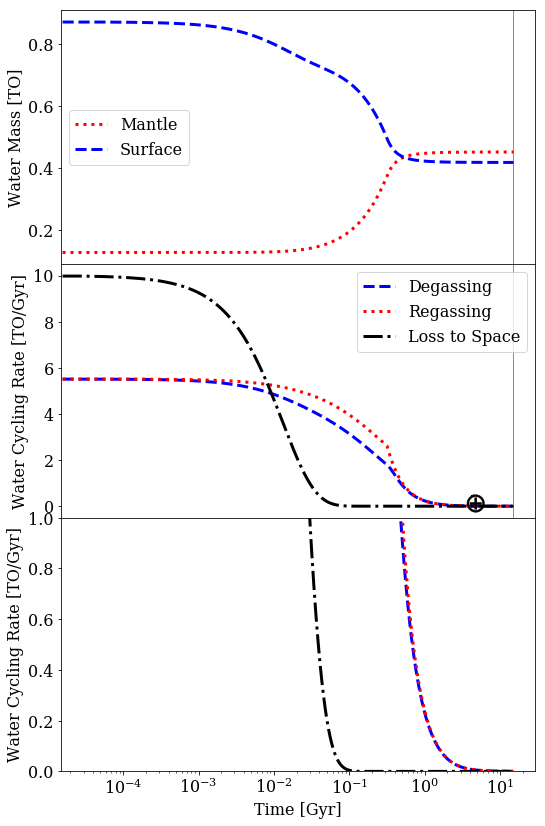

In [30]:
#Third panel zoomed in on the lower rates to better observe their behaviour.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,14))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M_E,params1,params2,params3,params4)*tau(M_E,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(3,1,1)
# WATER INVENTORIES IN TO
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
#plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(3,1,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 1.8e12/1.4e21*1.0e9, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 1.8e12/1.4e21*1.0e9, yerr=1.1e12/(1.4e21*1.0e9), ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
#plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylabel('Water Cycling Rate [TO/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

ax = plt.subplot(3,1,3)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 1.8e12/1.4e21*1.0e9, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 1.8e12/1.4e21*1.0e9, yerr=1.1e12/(1.4e21*1.0e9), ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
#plt.xlim([1.0e-4,15.])
plt.ylim([-0., 1.])
#plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylabel('Water Cycling Rate [TO/Gyr]', fontsize=16)
#plt.legend(loc='upper right', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Param_space_hyb_model_cycling_exploss_3panel.pdf', bbox_inches='tight')
#plt.savefig('Param_space_hyb_model_cycling_extremeloss_3panel.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


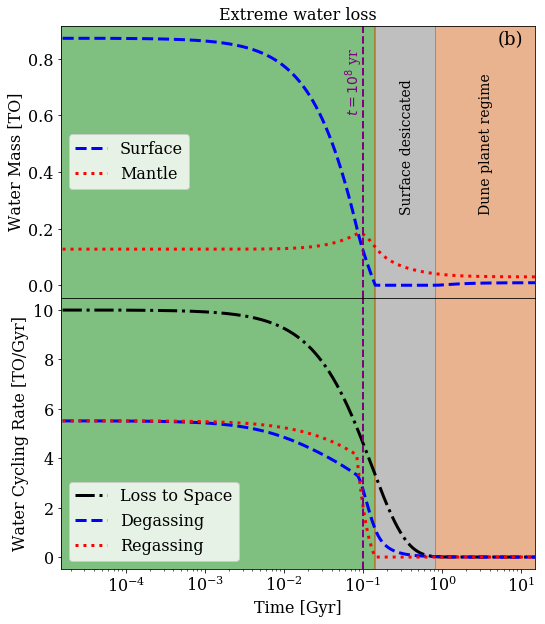

In [26]:
#Two panel only, if zooming doesn't add much

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M_E,params1,params2,params3,params4)*tau(M_E,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(2,1,1)
# WATER INVENTORIES IN TO
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT IS EARTH-LIKE (Short)
#plt.axvspan(1.5e-5,15.,alpha=0.5,color='green')

# FILL IN REGION WHERE IT IS EARTH-LIKE(Extreme)
plt.axvspan(1.5e-5,t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9,alpha=0.5,color='green')
# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')

# Label for putting figures side-by-side in paper.
# Short loss
#plt.text(5., 0.85, '(a)', fontsize=18)
# Extreme loss
plt.text(5., 0.85, '(b)', fontsize=18)

# Vertical line indicating tau_loss.
# Short loss
#plt.axvline(x=1.0e-2, color='purple', linestyle='--', linewidth=2)
#plt.text(0.9e-2, 0.4, r'$t = 10^7$ yr', color='purple', rotation=90, rotation_mode='anchor', fontsize=14)
#Arrow pointing at wiggle in surface water, short loss
#plt.annotate("", xy=(1.5e-1, 0.7), xytext=(1.0, 0.7), arrowprops=dict(facecolor='magenta', edgecolor='magenta', shrink=0.))
#plt.text(1.15, 0.69, 'wiggle', color='magenta', fontsize=16)
# Extreme loss
plt.axvline(x=1.0e-1, color='purple', linestyle='--', linewidth=2)
plt.text(0.9e-1, 0.6, r'$t = 10^8$ yr', color='purple', rotation=90, rotation_mode='anchor', fontsize=14)
#Text labelling the surface water regimes.
plt.text(4.0e-1, 0.25, 'Surface desiccated', color='k', rotation=90, rotation_mode='anchor', fontsize=14)
plt.text(4.0, 0.25, 'Dune planet regime', color='k', rotation=90, rotation_mode='anchor', fontsize=14)

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([1.5e-5,15.])
#plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
plt.legend(loc='center left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.18, 1.0), ncol=2, fontsize=16)
#plt.title('Short water loss', fontsize=16)
plt.title('Extreme water loss', fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(2,1,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='k', linestyle='-.', label='Loss to Space')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_path_hyb[water_idx, factor_idx, time_idx, :]*dr_conv/1.4e21*1.0e9), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Regassing Stops')

#PRESENT-DAY EARTH DEGASSING AND REGASSING
#plt.plot(4.5, 1.8e12/1.4e21*1.0e9, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #regassing
#plt.errorbar(4.5, 1.8e12/1.4e21*1.0e9, yerr=1.1e12/(1.4e21*1.0e9), ecolor='r', capsize=5) #regassing uncertainty
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4) #degassing
#They overlap for extreme loss, even with error bars --- use a single black marker.
#plt.plot(4.5, 2.0e11/1.4e21*1.0e9, color='k', marker='$\oplus$', markersize=22, markeredgewidth=0.005) #degassing

# FILL IN REGION WHERE IT IS EARTH-LIKE (Short)
#plt.axvspan(1.5e-5,15.,alpha=0.5,color='green')

# FILL IN REGION WHERE IT IS EARTH-LIKE(Extreme)
plt.axvspan(1.5e-5,t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9,alpha=0.5,color='green')
# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

# Vertical line indicating tau_loss.
# Short loss
#plt.axvline(x=1.0e-2, color='purple', linestyle='--', linewidth=2)
###plt.text(1.0e-3, 3.5, r'$t = 10^7$ yr', color='purple', fontsize=14)
# Extreme loss
plt.axvline(x=1.0e-1, color='purple', linestyle='--', linewidth=2)
###plt.text(0.9e-1, 7, r'$t = 10^8$ yr', color='purple', rotation=90, rotation_mode='anchor', fontsize=14)

plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([1.5e-5,15.])
#plt.ylabel(r'Water Cycling Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.ylabel('Water Cycling Rate [TO/Gyr]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
#plt.legend(bbox_to_anchor=(0.05, 1.0), ncol=2, fontsize=16)

#plt.savefig('Param_space_hyb_model_cycling_exploss_2panel.pdf', bbox_inches='tight')
#plt.savefig('Param_space_hyb_model_cycling_extremeloss_2panel.pdf', bbox_inches='tight')

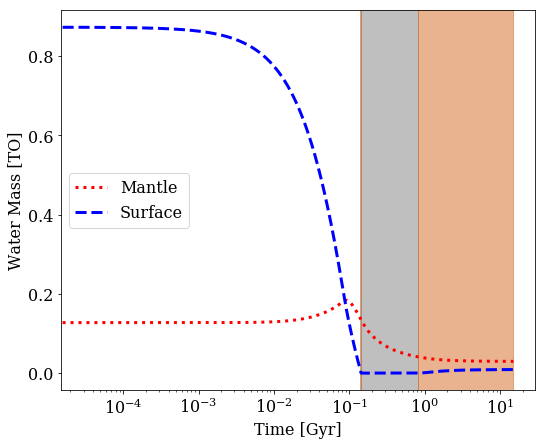

In [40]:
# ONE PANEL -- just show evolution of reservoirs over time
# Good for talks!

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7))
plt.tight_layout()
#ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
#fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

#ax = plt.subplot(3,1,1)
# WATER INVENTORIES IN TO
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_path_hyb[water_idx, factor_idx, time_idx, :]*kg_conv/1.4e21), linewidth=3, color='b', linestyle='--', label='Surface')
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3)#, label='Degassing Stops')
#plt.axvline(x=t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, label='Surface Desiccated')
#plt.axvline(x=t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='purple', linewidth=3, linestyle='-.', label='Ocean Rejuvenation')

# PRESENT-DAY MANTLE AND SURFACE WATER CONTENTS
#plt.plot(4.5, 2.36, color='r', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.plot(4.5, 1.4, color='b', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axhline(y=2.36, color='k', linestyle=':',linewidth=3,label=r'$x_{\oplus}$')
#plt.axhline(y=1.4, color='k', linestyle='--',linewidth=3, label=r'$s_{\oplus}$')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [TO]', fontsize=16)
plt.legend(loc='center left', fontsize=16)

#plt.savefig('Recoded_hyb_model_cycling_noloss_1panel_talk.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss_1panel_talk.png', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss_1panel_talk.png', bbox_inches='tight')

In [90]:
# Calculate wet solidus temperature over time, to be plotted below.

T_sol_wet_array_hyb = np.zeros(len(t_array_hyb))

for idx in range(0,len(t_array_hyb)):
    #Mantle water mass fraction
    x_frac = x_path_hyb[water_idx, factor_idx, time_idx, idx]*omega_0*f_btwid/f_M
    #Wet solidus temperature
    T_sol_wet_array_hyb[idx] = T_sol_dry - (K_cnst*x_frac**gamma)

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


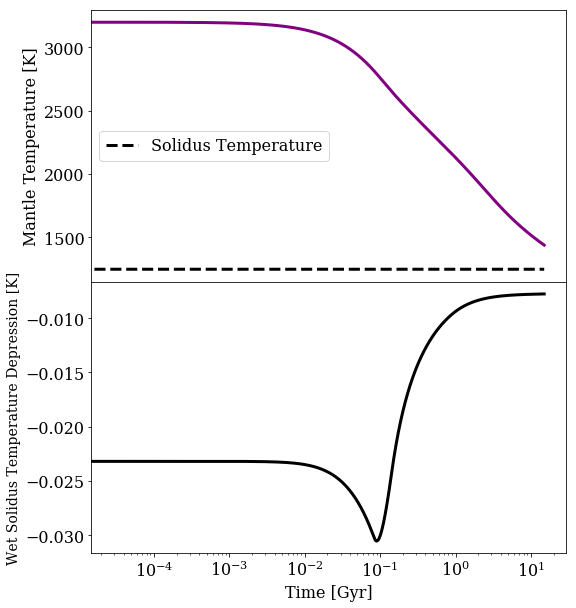

In [91]:
# Same plot as above, but instead of shaded regions, include wet solidus as a function of time, given current x.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,10))
plt.tight_layout()
ax = [fig.add_subplot(2,1,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

plt.subplot(2,1,1)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_path_hyb[water_idx, factor_idx, time_idx, :]*T_ref, linewidth=3, color='purple')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_sol_wet_array_hyb, linewidth=3, color='k', linestyle='--', label='Solidus Temperature')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.title('Mantle Temperature', fontsize=16)
plt.legend(loc='center left', fontsize=16)

plt.subplot(2,1,2)
#Plot wet solidus temperature as a function of time.
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, T_sol_wet_array_hyb-T_sol_dry, linewidth=3, color='k', linestyle='-', label='Solidus Temperature')

# FILL IN REGION WHERE IT FIRST BECOMES DUNE
#plt.axvspan(t_array_hyb[dune_first_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')
#FILL-IN REGION WHERE IT IS DESICCATED
#plt.axvspan(t_array_hyb[desiccated_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='grey')
# FILL IN REGION WHERE IT IS A DUNE PLANET
#plt.axvspan(t_array_hyb[recover_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, t_array_hyb[dune_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, alpha=0.5, color='chocolate')

#plt.plot(4.5, 1600, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
#plt.axvline(x=t_array_hyb[dg_off_idx_hyb]/tau(M_E,params1,params2,params3)/year/1.0e9, color='g', linestyle='-.', linewidth=3, label='Degassing Stops')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Wet Solidus Temperature Depression [K]', fontsize=14)
#plt.xlim([0.05,2])
#plt.ylim([np.min(T_sol_wet_array_hyb), np.max(T_sol_wet_array_hyb)])
#plt.legend(loc='center left', fontsize=16)
#plt.title('Wet Solidus Temperature Depression', fontsize=16)

#plt.savefig('Param_space_hyb_model_MantleTemp_exploss_wetsolidus.pdf', bbox_inches='tight')
#plt.savefig('Param_space_hyb_model_MantleTemp_extremeloss_wetsolidus.pdf', bbox_inches='tight')

In [92]:
print(T_path_hyb[water_idx, factor_idx, time_idx, -1]*T_ref)
print(T_sol_wet_array_hyb[-1])

1438.7477686080929
1248.1422370495682


## Check if planets become desiccated during their evolution, and if they recover a surface ocean by the end.

In [324]:
# Use the full grid parameter search for this.

# Check if planets become desiccated during their evolution, and whether they remain desiccated at 15 Gyr.
# Use the first parameter space for this.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_init_steadystate/'
tolerance = 1.29e16/kg_conv #surface is desiccated, below this limit
mid_desiccate_hyb = []
end_desiccate_hyb = []

file_idx = 0 #to print file number

for idx in range(0,len(initial_x_array)):
    
    for jdx in range(0,len(loss_rate_array)):
        
        for kdx in range(0,len(loss_time_array)):
    
            # Only want the first time s goes to zero, if it does, so use this check variable.
            check_hyb = 0
    
            # Check for desiccation during simulation.
            for ldx in range(0,len(s_path_hyb[idx,jdx,kdx,:])):
            
                if s_path_hyb[idx,jdx,kdx,ldx] < tolerance and check_hyb == 0:
                    mid_desiccate_hyb = np.append(mid_desiccate_hyb, filenums[file_idx])
                    check_hyb = 1
        
            if s_path_hyb[idx,jdx,kdx,-1] < tolerance:
                end_desiccate_hyb = np.append(end_desiccate_hyb, filenums[file_idx])
                
            file_idx = file_idx + 1 #update number for next file
        
print('Mid-simulation desiccation, initial steady-state : ', len(mid_desiccate_hyb))
print('Hyb: ', mid_desiccate_hyb)
print(' ')
print('End-of-simulation desiccation, initial steady-state: ', len(end_desiccate_hyb))
print('Hyb: ', end_desiccate_hyb)
print('Difference in length:', len(mid_desiccate_hyb) - len(end_desiccate_hyb))

Mid-simulation desiccation, initial steady-state :  20
Hyb:  ['003' '012' '013' '021' '022' '023' '030' '031' '032' '033' '113' '122'
 '123' '131' '132' '133' '223' '232' '233' '333']
 
End-of-simulation desiccation, initial steady-state:  10
Hyb:  ['003' '013' '023' '033' '113' '123' '133' '223' '233' '333']
Difference in length: 10


# Plot of final surface water vs. initial total water.
## See if it helps strengthen conclusions.

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


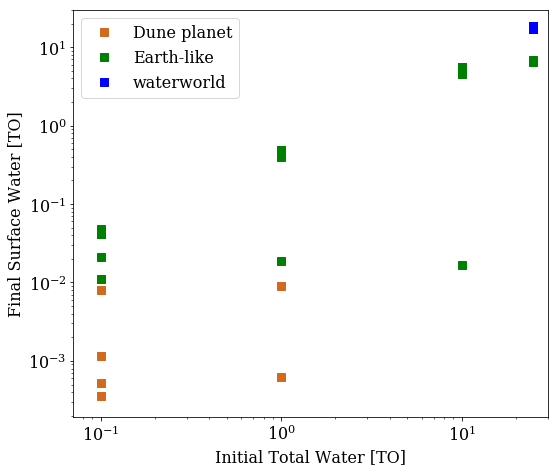

In [23]:
# Plot of surface water vs. total water -- see if it helps support conclusions

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb)):
    
    for jdx in range(0,len(loss_rate_array)):
        
        for kdx in range(0,len(loss_time_array)):
    
            # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
            if s_initial_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
                init_color_hyb = 'chocolate' #Dune planet
            elif s_initial_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
                init_color_hyb = 'green' #habitable
            elif s_initial_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
                init_color_hyb = 'b' #waterworld 

            # Choose corresponding colour for final values, for hybrid model.
            if s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
                fin_color_hyb = 'k'
                marker_hyb = 'x'
            elif s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 < 0.01*1.4:
                fin_color_hyb = 'chocolate' #Dune planet
                marker_hyb = 's'
            elif s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 < 10.0*1.4:
                fin_color_hyb = 'green' #habitable
                marker_hyb = 's'
            elif s_final_hyb[idx,jdx,kdx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
                fin_color_hyb = 'b' #waterworld
                marker_hyb = 's'
    
            # Actually plot the water.
            ax1.loglog((x_initial_hyb[idx,jdx,kdx]+s_initial_hyb[idx,jdx,kdx])*kg_conv/1.4e21, s_final_hyb[idx,jdx,kdx]*kg_conv/1.4e21, color=fin_color_hyb, marker=marker_hyb, linestyle='', markersize=8)     

# Handles for legend only
#ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel('Initial Total Water [TO]', fontsize=16)
ax1.set_ylabel('Final Surface Water [TO]', fontsize=16)
ax1.set_xlim(-1., 30.)
ax1.set_ylim(-1., 30.)

#ax2.set_xlim(-0.2, 42.)
#ax2.set_xticks([0., 7.0, 14.0, 21.0, 28.0, 35.0])
#ax2.set_xticklabels(['0', '5', '10', '15', '20', '25'])
#ax2.set_xlabel('Total Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-0.2, 35.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
plt.legend(loc='upper left', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Parameter_Search_Steadystate_hyb_totalwater_surfacewater.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')